Using cache found in C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main


Inference Time: 0.06245851516723633s
RSS (Memory Usage): 7.5 MB
VMS (Memory Usage): 95.6953125 MB
outputs:  tensor([[-4.7189, -2.6880, 10.2111, -3.2466]])
predicted:  tensor([2])
predicted_class Near-Miss Incidents
Image saved to: results/dino\sr_near_miss_incient_test_image.png


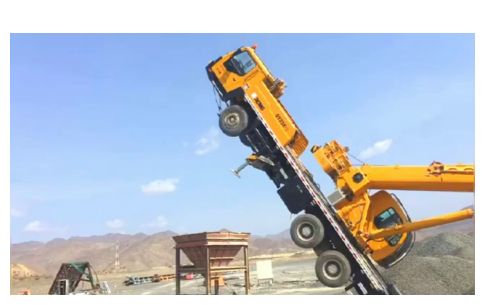

In [4]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import psutil
import time

img_path = "E:/[1]-Cascade learning-Unsafe behavior of cranes/ml_mo/safety_status_classification_module/classification/near_miss_incient.png"
class_names = ['Safe Operations', 'Unsafe Operations', 'Near-Miss Incidents', 'Incidents']
device = "cpu"
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)


class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self, n_classes=1):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        # x = torch.softmax(x)
        return x

model = DinoVisionTransformerClassifier(n_classes=len(class_names))
model = model.to(device)

# Paths and device setup
# folder = "pipeline_images"
# image_name = "B-TC (2009).png"  # Change image as needed
# img_path = os.path.join(folder, image_name)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Load the model
model_load_path = "./dino_model_epoch20.pth"
model = torch.load(model_load_path)
model = model.to(device)
model.eval()

def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

def measure_memory():
    process = psutil.Process()
    rss = process.memory_info().rss / (1024 * 1024)
    vms = process.memory_info().vms / (1024 * 1024)
    return rss, vms

def predict_image_class(image_path):
    image = preprocess_image(image_path)
    image = image.to(device)

    # Measure memory before inference
    rss_before, vms_before = measure_memory()
    start_time = time.time()

    with torch.no_grad():
        output = model(image)

    end_time = time.time()

    # Measure memory after inference
    rss_after, vms_after = measure_memory()

    # Calculate and print inference time
    inference_time = end_time - start_time
    print(f"Inference Time: {inference_time}s")

    # Calculate memory usage
    rss_usage = rss_after - rss_before
    vms_usage = vms_after - vms_before

    print(f"RSS (Memory Usage): {rss_usage} MB")
    print(f"VMS (Memory Usage): {vms_usage} MB")
    print("outputs: ",output)

    predicted = torch.argmax(output, dim=1)
    print("predicted: ",predicted)
    class_label = class_names[predicted.item()]
    return class_label

def display_image_with_label(image_path, class_label, save_fig=False):
    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted: {class_label}", fontsize=16, color='white')
    plt.axis('off')
    
    if save_fig:
        save_dir = 'results/dino'
        os.makedirs(save_dir, exist_ok=True)
        base_name = os.path.basename(image_path)
        save_path = os.path.join(save_dir, f'sr_{base_name}')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        print(f"Image saved to: {save_path}")
    
    plt.show()
img_path= "./near_miss_incient_test_image.png"
predicted_class = predict_image_class(img_path)
print("predicted_class",predicted_class)
display_image_with_label(img_path, predicted_class, save_fig=True)
